##  Development of FrED Run Condition Models.

Regression analysis of FrED run condition data to develop operational models for process optimization.

Uses auto porcessed run condition data - "Run Condition Data Summary.csv"

J. Cuiffi, - Penn State New Kensington

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sn
from mpl_toolkits.mplot3d import Axes3D
import pickle
from joblib import dump, load

In [2]:
# load run condition data into dataframe
# current file - 050820 11:06pm
path_local = 'C:/Users/cuiff/Dropbox/Python Common Library/python-fred/data/Reports/'
data = pd.read_csv(path_local + 'Run Condition Data Summary.csv')
data.head()

,Run File,Feed Rate Ave (RPS),Spool Wind Rate Set (RPS),Spool Rate Ave (RPS),Wind BF Rate Ave (PPS),Heater Set (C),Heater Temp Ave (C),Filament Diamter Ave (mm),Filament Std Dev (mm),System Power Ave (W),System Power Std Dev (W),Heater Current Ave (mA),Heater Current Std Dev (mA),Spool DC Motor Current Ave (mA),Spool DC Motor Current Std Dev (mA),Stepper and 12V Current Ave (mA),Stepper and 12V Current Std Dev (mA)
0,log_Manual Control__2020-04-12_12-13-50.csv,0.001000,1.00,1.000132,127.730719,90.0,90.009313,0.213487,0.016746,29.041052,1.000198,1778.186258,79.322377,134.912897,4.725082,506.607985,21.983723
1,log_Manual Control__2020-04-12_17-26-48.csv,0.000312,0.25,0.250982,20.426288,90.0,90.068162,0.228383,0.044286,30.064674,1.123981,1956.170717,89.196351,48.890935,2.843820,503.176947,23.016114
2,log_Manual Control__2020-04-12_17-26-48.csv,0.000312,0.50,0.499899,28.561457,90.0,90.080434,0.172805,0.012332,29.126951,1.001411,1849.457701,83.001875,76.481605,2.496682,503.087202,21.010638
3,log_Manual Control__2020-04-12_17-49-04.csv,0.000500,0.25,0.254232,45.159629,90.0,89.850642,0.302968,0.022932,28.685025,1.093912,1836.095309,89.052970,48.176519,4.276480,506.039012,19.272695
4,log_Manual Control__2020-04-12_17-49-04.csv,0.000500,0.50,0.499777,63.865360,90.0,90.043857,0.217002,0.014405,28.366543,0.931641,1785.295597,76.500593,75.523040,2.469729,507.120755,19.777991


In [3]:
# add a dataframe column that includes sqrt(feed speed / spool speed) as shown in our basic model
data['Sqrt Feed/Spool'] = np.sqrt(data['Feed Rate Ave (RPS)'] / data['Spool Rate Ave (RPS)'])
data.head()

,Run File,Feed Rate Ave (RPS),Spool Wind Rate Set (RPS),Spool Rate Ave (RPS),Wind BF Rate Ave (PPS),Heater Set (C),Heater Temp Ave (C),Filament Diamter Ave (mm),Filament Std Dev (mm),System Power Ave (W),System Power Std Dev (W),Heater Current Ave (mA),Heater Current Std Dev (mA),Spool DC Motor Current Ave (mA),Spool DC Motor Current Std Dev (mA),Stepper and 12V Current Ave (mA),Stepper and 12V Current Std Dev (mA),Sqrt Feed/Spool
0,log_Manual Control__2020-04-12_12-13-50.csv,0.001000,1.00,1.000132,127.730719,90.0,90.009313,0.213487,0.016746,29.041052,1.000198,1778.186258,79.322377,134.912897,4.725082,506.607985,21.983723,0.031621
1,log_Manual Control__2020-04-12_17-26-48.csv,0.000312,0.25,0.250982,20.426288,90.0,90.068162,0.228383,0.044286,30.064674,1.123981,1956.170717,89.196351,48.890935,2.843820,503.176947,23.016114,0.035286
2,log_Manual Control__2020-04-12_17-26-48.csv,0.000312,0.50,0.499899,28.561457,90.0,90.080434,0.172805,0.012332,29.126951,1.001411,1849.457701,83.001875,76.481605,2.496682,503.087202,21.010638,0.025003
3,log_Manual Control__2020-04-12_17-49-04.csv,0.000500,0.25,0.254232,45.159629,90.0,89.850642,0.302968,0.022932,28.685025,1.093912,1836.095309,89.052970,48.176519,4.276480,506.039012,19.272695,0.044348
4,log_Manual Control__2020-04-12_17-49-04.csv,0.000500,0.50,0.499777,63.865360,90.0,90.043857,0.217002,0.014405,28.366543,0.931641,1785.295597,76.500593,75.523040,2.469729,507.120755,19.777991,0.031630


### Fiber Diameter Modeling
Explore regression machine learning to develop a model for fiber diameter.

Fiber Diameter versus Sqrt(Feed/Spool)


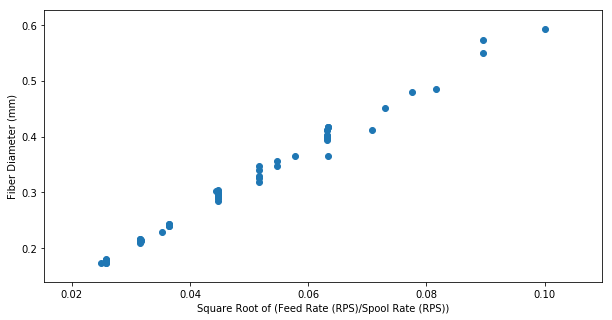

In [4]:
# plot filament diameter versus sqrt(feed/spool)
%matplotlib inline
fig, ax1 = plt.subplots()
fig.set_size_inches(10,5)
ax1.scatter(data['Sqrt Feed/Spool'],data['Filament Diamter Ave (mm)'])
ax1.set_xlabel('Square Root of (Feed Rate (RPS)/Spool Rate (RPS))')
ax1.set_ylabel('Fiber Diameter (mm)')
print('Fiber Diameter versus Sqrt(Feed/Spool)')

In [5]:
# perform a simple linear regression to develop a model for fiber diameter
# input data - reshaped to be a column vector
X = data['Sqrt Feed/Spool'].to_numpy().reshape(-1,1)
# target data - row vector
Y = data['Filament Diamter Ave (mm)'].to_numpy()
# create model, fit data, report coefficients
model = LinearRegression()
model.fit(X,Y)
print('Slope = ', model.coef_[0])
print('Intercept = ', model.intercept_)
print('Score (R^2) = ', model.score(X,Y))

Slope =  5.802830190291016
Intercept =  0.03145952131840202
Score (R^2) =  0.9905204454820381


Predicted Fiber Diameter versus Sqrt(Feed/Spool)


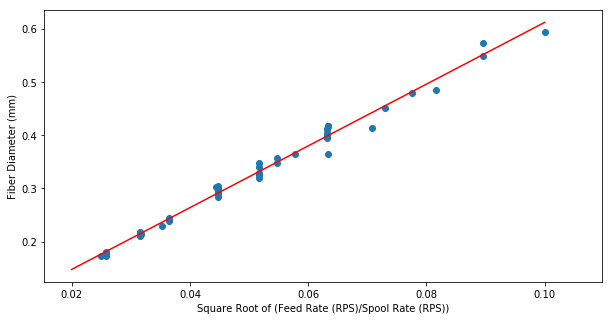

In [6]:
# plot model versus actual
# create prediction
X = np.linspace(.02,.1).reshape(-1,1)
Y = model.predict(X)
# plot together
fig, ax1 = plt.subplots()
fig.set_size_inches(10,5)
ax1.scatter(data['Sqrt Feed/Spool'],data['Filament Diamter Ave (mm)'])
ax1.plot(X,Y,c='red')
ax1.set_xlabel('Square Root of (Feed Rate (RPS)/Spool Rate (RPS))')
ax1.set_ylabel('Fiber Diameter (mm)')
print('Predicted Fiber Diameter versus Sqrt(Feed/Spool)')

<IPython.core.display.Javascript object>


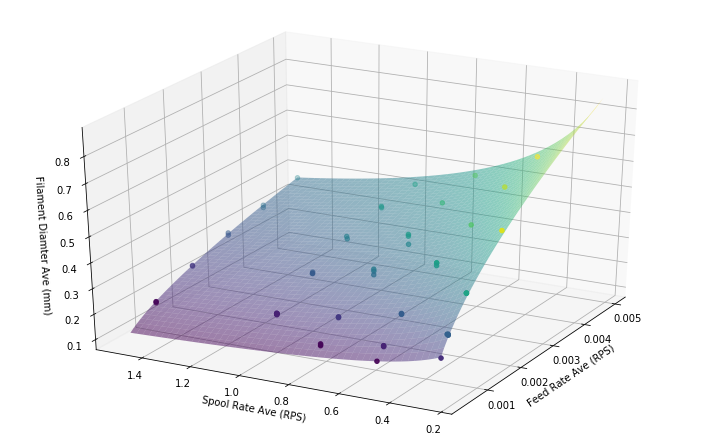

Fiber Diameter versus Feed and Spool Speed


In [8]:
# plot model as a 3D surface versus feed and spool speed
%matplotlib notebook
# create prediction using a meshgrid to represent x (feed) , y (spool) and z (diameter) values
feeds = np.linspace(.0003,.005)
spools = np.linspace(.25,1.5)
xx, yy = np.meshgrid(feeds, spools)
sqrts = np.sqrt(np.divide(xx,yy))
dias = model.predict(sqrts.flatten().reshape(-1,1))
zz = dias.reshape(xx.shape)
# plot
fig = plt.figure()
ax1 = Axes3D(fig)
ax1.scatter(data['Feed Rate Ave (RPS)'],data['Spool Rate Ave (RPS)'],data['Filament Diamter Ave (mm)'],c=data['Filament Diamter Ave (mm)'])
ax1.plot_surface(xx,yy,zz,cmap=plt.cm.viridis,alpha=.5)
ax1.set_xlabel('Feed Rate Ave (RPS)')
ax1.set_ylabel('Spool Rate Ave (RPS)')
ax1.set_zlabel('Filament Diamter Ave (mm)')
print('Fiber Diameter versus Feed and Spool Speed')

Fiber Diameter versus Feed and Spool Speed


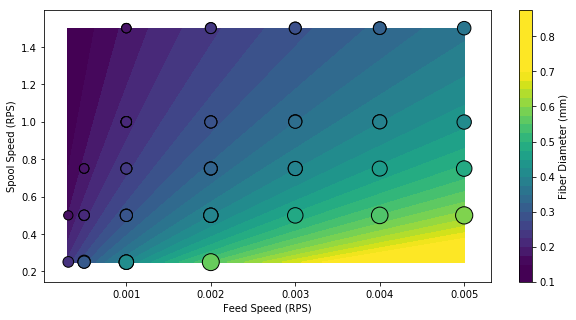

In [9]:
# showing the above in a 2D plot
%matplotlib inline
fig, ax1 = plt.subplots()
fig.set_size_inches(10,5)
CS = ax1.contourf(xx,yy,zz, levels=30, alpha=1.0, vmin=0.15, vmax=.7)
ax1.scatter(data['Feed Rate Ave (RPS)'],data['Spool Rate Ave (RPS)'], s=500*data['Filament Diamter Ave (mm)'], c=data['Filament Diamter Ave (mm)'],edgecolors='black',vmin=0.15, vmax=.7)
ax1.set_ylabel('Spool Speed (RPS)')
ax1.set_xlabel('Feed Speed (RPS)')
CB = fig.colorbar(CS)
CB.ax.set_ylabel('Fiber Diameter (mm)')
print('Fiber Diameter versus Feed and Spool Speed')

In [10]:
# Add heater temperature for multi-variable regression
# input data - autmatically reshaped to be column vectors
X = data[['Sqrt Feed/Spool','Heater Temp Ave (C)']].to_numpy()
#print(X)
# target data - row vector
Y = data['Filament Diamter Ave (mm)'].to_numpy()
# create model, fit data, report coefficients
model2 = LinearRegression()
model2.fit(X,Y)
print('Slopes = ', model2.coef_)
print('Intercept = ', model2.intercept_)
print('Score (R^2) = ', model2.score(X,Y))

Slopes =  [5.83116286e+00 4.17516686e-04]
Intercept =  -0.004973260581682903
Score (R^2) =  0.990761373259778


<IPython.core.display.Javascript object>


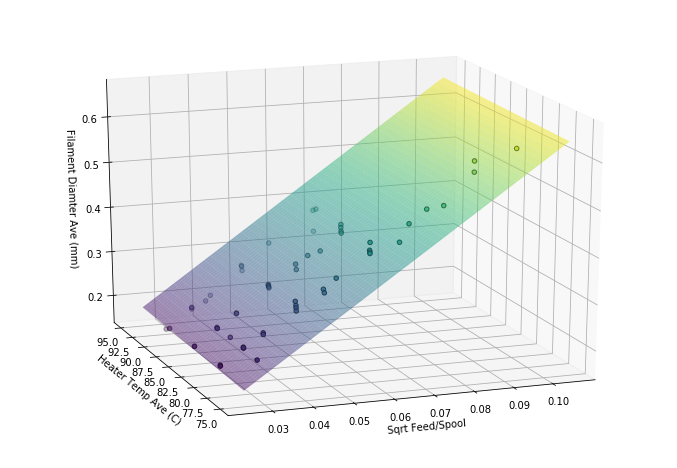

Fiber Diameter Model versus Sqrt (feed/spool) and Temperature


In [11]:
# plot model as a 3D surface versus sqrt feed/spool and temperature
%matplotlib notebook
# create prediction using a meshgrid to represent x (sqrt(feed/spool)) and z (diameter) values
sqrts = np.linspace(.025,.105)
temps = np.linspace(75,95)
xx, yy = np.meshgrid(sqrts, temps)
#print(xx.flatten())
#np.array([xx.flatten(),yy.flatten()]).T
dias = model2.predict(np.array([xx.flatten(),yy.flatten()]).T)
zz = dias.reshape(xx.shape)
# plot
fig = plt.figure()
ax1 = Axes3D(fig)
ax1.scatter(data['Sqrt Feed/Spool'],data['Heater Temp Ave (C)'],data['Filament Diamter Ave (mm)'],c=data['Filament Diamter Ave (mm)'],edgecolors='black',vmin=.15,vmax=.65)
ax1.plot_surface(xx,yy,zz,cmap=plt.cm.viridis,alpha=.5,vmin=.15,vmax=.65)
ax1.set_xlabel('Sqrt Feed/Spool')
ax1.set_ylabel('Heater Temp Ave (C)')
ax1.set_zlabel('Filament Diamter Ave (mm)')
print('Fiber Diameter Model versus Sqrt (feed/spool) and Temperature')

In [12]:
# show multi-variable regression with a polynomial modifier (4th degree shown)
pipe = Pipeline([('poly', PolynomialFeatures(degree=4)),('linreg', LinearRegression())])
X = data[['Feed Rate Ave (RPS)','Spool Rate Ave (RPS)','Heater Temp Ave (C)']].to_numpy()
Y = data['Filament Diamter Ave (mm)'].to_numpy()
model3 = pipe.fit(X,Y)
print('Coefficients = ', model3.named_steps['linreg'].coef_)
print('Intercept = ', model3.named_steps['linreg'].intercept_)
print('Score (R^2) = ', model3.score(X,Y))

Coefficients =  [-1.38333850e+04  3.05082771e+05 -7.99177495e+02 -2.31990783e+01
 -1.92031989e+04 -1.21357652e+03 -1.08159461e+04 -4.78690790e-01
  2.82931367e+01  3.13915698e-01 -7.27652031e+02 -2.78063977e+05
  4.29778719e+03  1.04247185e+03  1.38345240e+01  1.27717465e+02
 -3.60125793e-01  2.60421468e-02 -3.33762674e-01 -1.70976208e-03
 -1.03407440e+01 -1.32739715e+03  5.64714942e+03 -1.43894043e+04
  3.88793784e+03 -5.53565528e+01 -7.28530068e+01 -8.93949548e+00
 -5.83368594e-02 -5.01696898e-01 -2.21322886e-01  1.10023686e-02
 -2.81707884e-04  1.31164714e-03  2.81006743e-06]
Intercept =  14440.812827407366
Score (R^2) =  0.9960060426153632


<IPython.core.display.Javascript object>


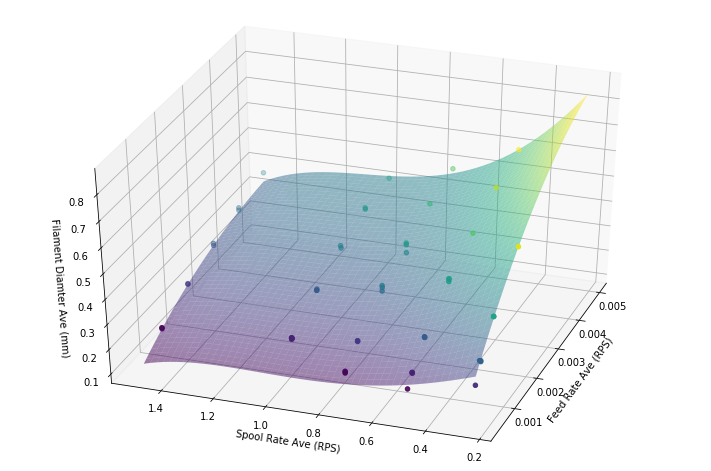

Fiber Diameter versus Feed and Spool Speed


In [13]:
# plot with 4th order model, setting one temeprature
feeds = np.linspace(.0003,.005)
spools = np.linspace(.25,1.5)
# choose 80C
temps = np.ones(50)*80
xx, yy, aa = np.meshgrid(feeds, spools, temps)
dias = model3.predict(np.array([xx.flatten(),yy.flatten(),aa.flatten()]).T)
zz = dias.reshape(xx.shape)
# plot
fig = plt.figure()
ax1 = Axes3D(fig)
ax1.scatter(data['Feed Rate Ave (RPS)'],data['Spool Rate Ave (RPS)'],data['Filament Diamter Ave (mm)'],c=data['Filament Diamter Ave (mm)'])
ax1.plot_surface(xx[:,:,0],yy[:,:,0],zz[:,:,0],cmap=plt.cm.viridis,alpha=.5)
ax1.set_xlabel('Feed Rate Ave (RPS)')
ax1.set_ylabel('Spool Rate Ave (RPS)')
ax1.set_zlabel('Filament Diamter Ave (mm)')
print('Fiber Diameter versus Feed and Spool Speed')

In [14]:
# show a support vector machine model
pipe = Pipeline([('scale', StandardScaler()),('svr', SVR(C=1.0, epsilon=0.01))])
X = data[['Feed Rate Ave (RPS)','Spool Rate Ave (RPS)','Heater Temp Ave (C)']].to_numpy()
Y = data['Filament Diamter Ave (mm)'].to_numpy()
model4 = pipe.fit(X,Y)
print('Score (R^2) = ', model4.score(X,Y))

Score (R^2) =  0.9923640867627394


<IPython.core.display.Javascript object>


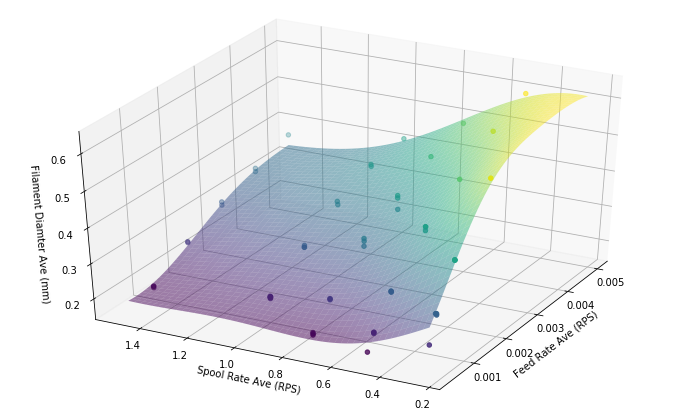

Fiber Diameter versus Feed and Spool Speed


In [15]:
# plot with SVM model, setting one temeprature
feeds = np.linspace(.0003,.005)
spools = np.linspace(.25,1.5)
# choose 80C
temps = np.ones(50)*80
xx, yy, aa = np.meshgrid(feeds, spools, temps)
dias = model4.predict(np.array([xx.flatten(),yy.flatten(),aa.flatten()]).T)
zz = dias.reshape(xx.shape)
# plot
fig = plt.figure()
ax1 = Axes3D(fig)
ax1.scatter(data['Feed Rate Ave (RPS)'],data['Spool Rate Ave (RPS)'],data['Filament Diamter Ave (mm)'],c=data['Filament Diamter Ave (mm)'])
ax1.plot_surface(xx[:,:,0],yy[:,:,0],zz[:,:,0],cmap=plt.cm.viridis,alpha=.5)
ax1.set_xlabel('Feed Rate Ave (RPS)')
ax1.set_ylabel('Spool Rate Ave (RPS)')
ax1.set_zlabel('Filament Diamter Ave (mm)')
print('Fiber Diameter versus Feed and Spool Speed')

### Fiber Diameter - Standard Deviation Modeling
Develop a model for standard deviation with unknown influences.

In [84]:
# multi-variable regression with a polynomial modifier
pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),('linreg', LinearRegression())])
X = data[['Feed Rate Ave (RPS)','Spool Rate Ave (RPS)','Heater Temp Ave (C)']].to_numpy()
Y = data['Filament Std Dev (mm)'].to_numpy()
model5 = pipe.fit(X,Y)
print('Score (R^2) = ', model5.score(X,Y))

Score (R^2) =  0.5510268240028662


<IPython.core.display.Javascript object>


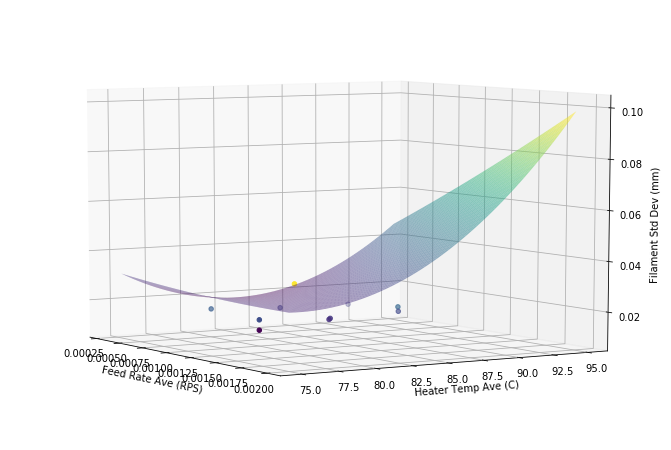

Fiber Diameter Std Dev versus Feed and Temperature (.214mm nom)


In [72]:
# plot result at a given fiber diameter- .214mm
feeds = np.linspace(.0003,.002)
# solve for spool rates using simple equation
spools = feeds / (.214/5.8)**2
#print(spools)
temps = np.linspace(75,95)
xx, yy, aa = np.meshgrid(feeds, spools, temps)
#print(xx)
#print(xx[:,:,0])
#
#print(yy)
#print(aa)
dias = model5.predict(np.array([xx.flatten(),yy.flatten(),aa.flatten()]).T)
zz = dias.reshape(xx.shape)
# clip .214mm data from frame
df = data[data['Filament Diamter Ave (mm)'] < .22]
df = df[df['Filament Diamter Ave (mm)'] > .21]
# plot
fig = plt.figure()
ax1 = Axes3D(fig)
ax1.scatter(df['Feed Rate Ave (RPS)'],df['Heater Temp Ave (C)'],df['Filament Std Dev (mm)'],c=df['Filament Std Dev (mm)'])
ax1.plot_surface(xx[0,:,:],aa[0,:,:],zz[0,:,:],cmap=plt.cm.viridis,alpha=.5)
ax1.set_xlabel('Feed Rate Ave (RPS)')
ax1.set_ylabel('Heater Temp Ave (C)')
ax1.set_zlabel('Filament Std Dev (mm)')
print('Fiber Diameter Std Dev versus Feed and Temperature (.214mm nom)')

<IPython.core.display.Javascript object>


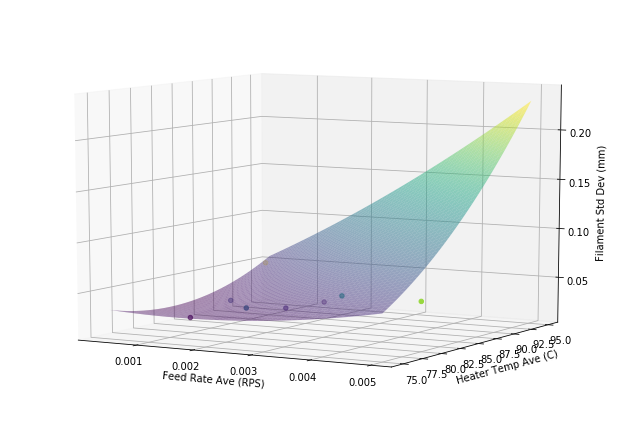

Fiber Diameter Std Dev versus Feed and Temperature (.41mm nom)


In [76]:
# plot result at a given fiber diameter- .41mm
feeds = np.linspace(.0003,.005)
# solve for spool rates using simple equation
spools = feeds / (.41/5.8)**2
#print(spools)
temps = np.linspace(75,95)
xx, yy, aa = np.meshgrid(feeds, spools, temps)
dias = model5.predict(np.array([xx.flatten(),yy.flatten(),aa.flatten()]).T)
zz = dias.reshape(xx.shape)
# clip .214mm data from frame
df = data[data['Filament Diamter Ave (mm)'] < .42]
df = df[df['Filament Diamter Ave (mm)'] > .4]
# plot
fig = plt.figure()
ax1 = Axes3D(fig)
ax1.scatter(df['Feed Rate Ave (RPS)'],df['Heater Temp Ave (C)'],df['Filament Std Dev (mm)'],c=df['Filament Std Dev (mm)'])
ax1.plot_surface(xx[0,:,:],aa[0,:,:],zz[0,:,:],cmap=plt.cm.viridis,alpha=.5)
ax1.set_xlabel('Feed Rate Ave (RPS)')
ax1.set_ylabel('Heater Temp Ave (C)')
ax1.set_zlabel('Filament Std Dev (mm)')
print('Fiber Diameter Std Dev versus Feed and Temperature (.41mm nom)')

### Power Consumption Modeling
Develop a model for Power with unknown influences.

In [78]:
# multi-variable regression with a polynomial modifier
pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),('linreg', LinearRegression())])
X = data[['Feed Rate Ave (RPS)','Spool Rate Ave (RPS)','Heater Temp Ave (C)']].to_numpy()
Y = data['System Power Ave (W)'].to_numpy()
model6 = pipe.fit(X,Y)
print('Score (R^2) = ', model6.score(X,Y))

Score (R^2) =  0.8980641185337678


<IPython.core.display.Javascript object>


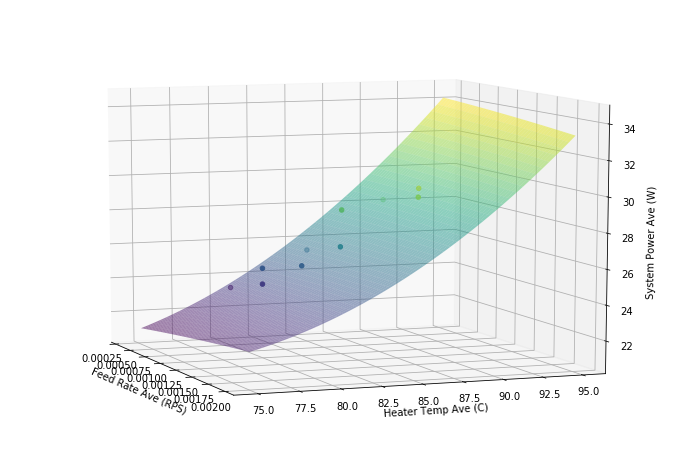

System Power Ave (W) versus Feed and Temperature (.214mm nom)


In [81]:
# plot result at a given fiber diameter- .214mm
feeds = np.linspace(.0003,.002)
# solve for spool rates using simple equation
spools = feeds / (.214/5.8)**2
#print(spools)
temps = np.linspace(75,95)
xx, yy, aa = np.meshgrid(feeds, spools, temps)
dias = model6.predict(np.array([xx.flatten(),yy.flatten(),aa.flatten()]).T)
zz = dias.reshape(xx.shape)
# clip .214mm data from frame
df = data[data['Filament Diamter Ave (mm)'] < .22]
df = df[df['Filament Diamter Ave (mm)'] > .21]
# plot
fig = plt.figure()
ax1 = Axes3D(fig)
ax1.scatter(df['Feed Rate Ave (RPS)'],df['Heater Temp Ave (C)'],df['System Power Ave (W)'],c=df['System Power Ave (W)'])
ax1.plot_surface(xx[0,:,:],aa[0,:,:],zz[0,:,:],cmap=plt.cm.viridis,alpha=.5)
ax1.set_xlabel('Feed Rate Ave (RPS)')
ax1.set_ylabel('Heater Temp Ave (C)')
ax1.set_zlabel('System Power Ave (W)')
print('System Power Ave (W) versus Feed and Temperature (.214mm nom)')

<IPython.core.display.Javascript object>


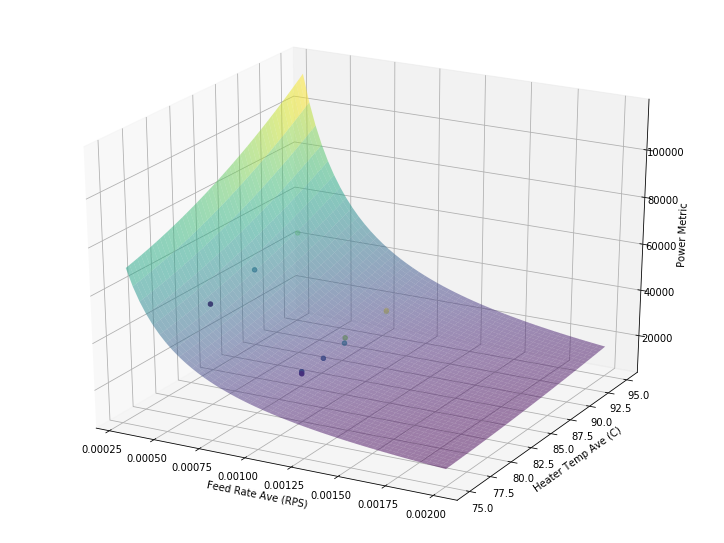

Power Metric versus Feed and Temperature (.214mm nom)


In [82]:
# plot power/production metric at a given fiber diameter- .214mm
feeds = np.linspace(.0003,.002)
# solve for spool rates using simple equation
spools = feeds / (.214/5.8)**2
#print(spools)
temps = np.linspace(75,95)
xx, yy, aa = np.meshgrid(feeds, spools, temps)
dias = model6.predict(np.array([xx.flatten(),yy.flatten(),aa.flatten()]).T)
zz = dias.reshape(xx.shape)
# clip .214mm data from frame
df = data[data['Filament Diamter Ave (mm)'] < .22]
df = df[df['Filament Diamter Ave (mm)'] > .21]
# plot
fig = plt.figure()
ax1 = Axes3D(fig)
ax1.scatter(df['Feed Rate Ave (RPS)'],df['Heater Temp Ave (C)'],df['System Power Ave (W)']/df['Feed Rate Ave (RPS)'],c=df['System Power Ave (W)'])
ax1.plot_surface(xx[0,:,:],aa[0,:,:],zz[0,:,:]/xx[0,:,:],cmap=plt.cm.viridis,alpha=.5)
ax1.set_xlabel('Feed Rate Ave (RPS)')
ax1.set_ylabel('Heater Temp Ave (C)')
ax1.set_zlabel('Power Metric')
print('Power Metric versus Feed and Temperature (.214mm nom)')

### Export Models
Save models in files to import in other code. Uses pickle.

In [95]:
model_path = './Models/'
# linear regression for fiber diameter - model2
# inputs ['Sqrt Feed/Spool','Heater Temp Ave (C)']
dump(model2, model_path + 'dia_mod_1.p')

# polynomial regression (order 2) for fiber standard deviation - model5
# inputs ['Feed Rate Ave (RPS)','Spool Rate Ave (RPS)','Heater Temp Ave (C)']
dump(model5, model_path + 'dia_std_mod_1.p')

# polynomial regression (order 2) for system power - model6
# inputs ['Feed Rate Ave (RPS)','Spool Rate Ave (RPS)','Heater Temp Ave (C)']
dump(model6, model_path + 'sys_pow_mod_1.p')

['./Models/sys_pow_mod_1.p']

### 3D Slice Practice and Examples

In [64]:
a = np.linspace(0,2,3)
b = np.linspace(3,5,3)
c = np.linspace(6,8,3)
#print(a)
#print(b)
#print(c)
aa, bb, cc = np.meshgrid(a,b,c)
print(aa)
print(aa[:,1,:])
print('**')
print(bb)
print(cc)
yy = aa + bb + cc
print(yy)
print('**')
print(yy[0,:,:])

[[[0. 0. 0.]
  [1. 1. 1.]
  [2. 2. 2.]]

 [[0. 0. 0.]
  [1. 1. 1.]
  [2. 2. 2.]]

 [[0. 0. 0.]
  [1. 1. 1.]
  [2. 2. 2.]]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
**
[[[3. 3. 3.]
  [3. 3. 3.]
  [3. 3. 3.]]

 [[4. 4. 4.]
  [4. 4. 4.]
  [4. 4. 4.]]

 [[5. 5. 5.]
  [5. 5. 5.]
  [5. 5. 5.]]]
[[[6. 7. 8.]
  [6. 7. 8.]
  [6. 7. 8.]]

 [[6. 7. 8.]
  [6. 7. 8.]
  [6. 7. 8.]]

 [[6. 7. 8.]
  [6. 7. 8.]
  [6. 7. 8.]]]
[[[ 9. 10. 11.]
  [10. 11. 12.]
  [11. 12. 13.]]

 [[10. 11. 12.]
  [11. 12. 13.]
  [12. 13. 14.]]

 [[11. 12. 13.]
  [12. 13. 14.]
  [13. 14. 15.]]]
**
[[ 9. 10. 11.]
 [10. 11. 12.]
 [11. 12. 13.]]
